## Building an ARIMA model 
General steps for forecasting using ARMA models:
- Plot the data and identify any unusual observations.
- If necessary, transform the data (using a Box-Cox transformation) to stabilise the variance.
- If the data are non-stationary, take first differences of the data until the data are stationary.
- Examine the ACF/PACF: is an ARIMA (p,d,0) or ARIMA (0,d,q) model appropriate? 
- Try chosen model(s), and use the AICc to search for a better mdoel
- Check residuals from chosen model by plotting the ACF of the residuals, and doing a portmanteau test of the residuals. If they do not look like white noise, try modified model
- Once residuals look like white noise, calculate forecasts. 

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from statsmodels.tsa import stattools

In [2]:
def patch_missing_dates(df):
    missing = pd.date_range(start=df.index.min(),  end=df.index.max()).difference(df.index)
    df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max()),method='ffill')
    if not missing.empty:
        print('dates missing:', missing)
        print('filling with forward fill - propagating last valid observation to next')
    return df 


In [24]:
# load your dataset
data_dir = os.path.join(os.getcwd(), 'data_files')

target_df = pd.read_csv(os.path.join(data_dir, 'targets.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df = pd.read_csv(os.path.join(data_dir, 'predictors.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df['Holiday'] = predictor_df['Holiday'].astype(int)

df = pd.DataFrame(target_df['SoCal_TOTAL']).join(predictor_df).sort_index(ascending=True)
train_df = df[df.index<pd.to_datetime('4/1/21')]
test_df = df[df.index>=pd.to_datetime('4/1/21')]

In [25]:
region = 'SoCal' # can be SD or SoCal
# recapitulating vbDLFM with lags
targets_train = train_df[region+ '_TOTAL']
targets_test = test_df[region+ '_TOTAL']
predictors_train = train_df[[region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7','Holiday']]

predictors_test = test_df[[region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7','Holiday']]

# fixnan dates
predictors_train = patch_missing_dates(predictors_train.dropna()).asfreq('D')
predictors_test = patch_missing_dates(predictors_test.dropna().asfreq('D'))


dates missing: DatetimeIndex(['2017-04-12', '2018-08-08'], dtype='datetime64[ns]', freq=None)
filling with forward fill - propagating last valid observation to next


In [53]:
smax = SARIMAX(endog=targets_train, exog=predictors_train, freq='D', 
               order=(4, 1, 1), seasonal_order=(0,0,0,0),
              mle_regression=True).fit(maxiter=200)
# smax = SARIMAX(endog=targets_train, exog=predictors_train, freq='D', 
#               mle_regression=True).fit(maxiter=200)
smax.summary()

C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SoCal_TOTAL   No. Observations:                 1796
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -9341.858
Date:                Fri, 06 Aug 2021   AIC                          18713.717
Time:                        17:00:34   BIC                          18796.108
Sample:                    05-01-2016   HQIC                         18744.135
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
SoCal_HDD          26.9231      0.678     39.713      0.000      25.594      28.252
SoCal_t-1_HDD      16.0899      0.822     19.578      0.000      14.479      17.701
SoCal_t-2_HDD       4.8777      0.478     10.196      0.000       3.940       5.815
SoCal_t-3_HDD       2.3408      0.455      5.140      0.000       1.448       3.233
SoCal_CDD          -3.7406      1.343     -2.785      0.005      -6.373      -1.108
SoCal_t-1_CDD      -2.4233      1.004     -2.415      0.016      -4.390      -0.456
SoCal_HDD_7        26.3498      1.049     25.122      0.000      24.294      28.406
SoCal_t-1_HDD_7    -0.3407      1.199     -0.284      0.776      -2.690       2.009
Holiday             3.8662      4.059      0.952      0.341      -4.090      11.822
ar.L1               0.4581      0.032     14.276      0.000       0.395       0.521
ar.L2              -0.1551      0.019     -8.237      0.000      -0.192      -0.118
ar.L3              -0.0289      0.022     -1.342      0.179      -0.071       0.013
ar.L4              -0.0596      0.020     -2.925      0.003      -0.100      -0.020
ma.L1              -0.7574      0.030    -25.566      0.000      -0.815      -0.699
sigma2           1938.6509     34.684     55.894      0.000    1870.671    2006.631
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2804.35
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
smax.mle_retvals

{'fopt': 5.202905922714571,
 'gopt': array([ 1.05035980e-06, -7.37960804e-06, -1.97815098e-06,  1.97992733e-06,
        -6.83089141e-06, -1.52038382e-06, -6.83515466e-06,  1.78355108e-06,
        -4.26325641e-07, -4.00096845e-05, -5.22890176e-05,  2.90675928e-05,
         5.33972866e-07]),
 'fcalls': 1708,
 'warnflag': 0,
 'converged': True,
 'iterations': 105}

In [31]:
arima_fit = pm.auto_arima(y=targets_train, X=predictors_train, seasonal=True, m=7)
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1796
Model:             SARIMAX(2, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -9308.388
Date:                                Fri, 06 Aug 2021   AIC                          18646.776
Time:                                        16:24:06   BIC                          18729.168
Sample:                                    05-01-2016   HQIC                         18677.195
                                         - 03-31-2021                                         
Covariance Type:                                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
SoCal_HDD          27.0598      0.646     41.920      0.000      25.795      28.325
SoCal_t-1_HDD      16.0103      0.775     20.667      0.000      14.492      17.529
SoCal_t-2_HDD       4.7734      0.461     10.347      0.000       3.869       5.678
SoCal_t-3_HDD       2.3148      0.442      5.243      0.000       1.449       3.180
SoCal_CDD          -3.8026      1.286     -2.958      0.003      -6.322      -1.283
SoCal_t-1_CDD      -2.3023      0.983     -2.343      0.019      -4.228      -0.376
SoCal_HDD_7        26.4581      1.004     26.344      0.000      24.490      28.427
SoCal_t-1_HDD_7    -0.1097      1.132     -0.097      0.923      -2.328       2.109
Holiday             5.7820      3.889      1.487      0.137      -1.841      13.405
ar.L1               0.5645      0.019     29.371      0.000       0.527       0.602
ar.L2              -0.0894      0.018     -4.837      0.000      -0.126      -0.053
ma.L1              -0.8696      0.015    -57.620      0.000      -0.899      -0.840
ma.S.L7             0.1316      0.019      7.089      0.000       0.095       0.168
ma.S.L14            0.1353      0.015      8.775      0.000       0.105       0.165
sigma2           1873.2686     32.950     56.852      0.000    1808.688    1937.849
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2944.79
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

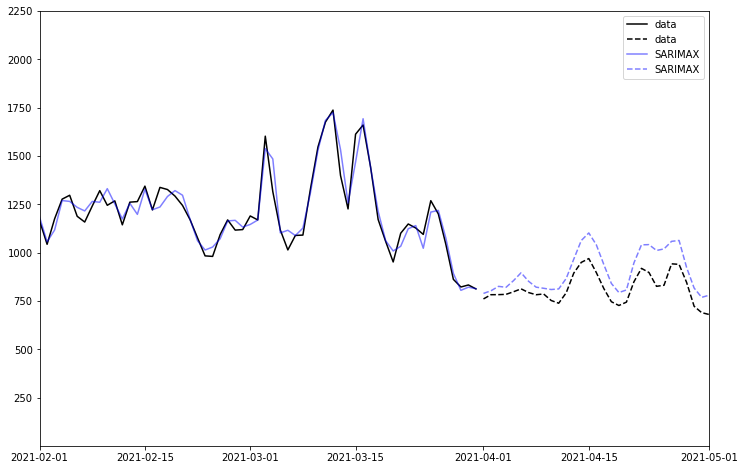

In [54]:
pred_test =smax.predict(test_df.index.min(), test_df.index.max(), exog=predictors_test, full_results=True, alpha=0.05)

pred_train =smax.predict(train_df.index.min(), train_df.index.max(), exog=predictors_train, full_results=True, alpha=0.05)

# You can then plot it (import matplotlib first)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
#Actual data
ax.plot(train_df['SoCal_TOTAL'].astype('float64'), 'k-',label='data')
ax.plot(test_df['SoCal_TOTAL'].astype('float64'), 'k--',label='data')
# Means
ax.plot(pred_train, 'b-', alpha=0.5, label='SARIMAX')
ax.plot(pred_test, 'b--', alpha=0.5, label='SARIMAX')
ax.legend(loc='upper right')
ax.set_xlim([pd.to_datetime('2/1/21'), pd.to_datetime('5/1/21')])
plt.draw()

In [44]:
pct_errors = (1-(pred_means/test_df['SoCal_TOTAL']))*100

np.mean(pct_errors)

-14.632750285241421

In [50]:
# identify whether target series is stationary by checking acf plot
def acf_plots(data, nlags, seasonal_m):
    acf_values = []
    for k in np.arange(0,nlags+1):
        acf_values.append(data.diff(seasonal_m).dropna().autocorr(lag=k))
    acf_5cv = 1.96/np.sqrt(len(df['SoCal_TOTAL']) - np.arange(0, nlags+1))
    pacf_values = stattools.pacf(data, nlags=nlags)
    
    print(len(acf_values), len(pacf_values))
    
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    sns.lineplot(data=data, ax=ax1)

    pd.plotting.autocorrelation_plot(data, ax=ax2)
    ax2.set_title('Original ACF'), ax2.set_ylim([-1, 1]), ax2.set_xlim([0, nlags])

    sns.lineplot(data=pacf_values, ax=ax3)
    ax3.plot(np.arange(0, nlags+1), acf_5cv, 'k--')
    ax3.plot(np.arange(0, nlags+1), acf_5cv*-1, 'k--')
    ax3.set_title('PACF'), ax3.set_xlabel('Lag'), ax3.set_xlim([0, nlags])

    plt.tight_layout(), plt.show()
    
    marks_df = pd.DataFrame({'ACF': acf_values,
                             'PACF': pacf_values,
                             '5CV': acf_5cv,})
    
    adf_p = stattools.adfuller(data)[1]
    print('stationary if sig:', adf_p)
    return marks_df

101 101


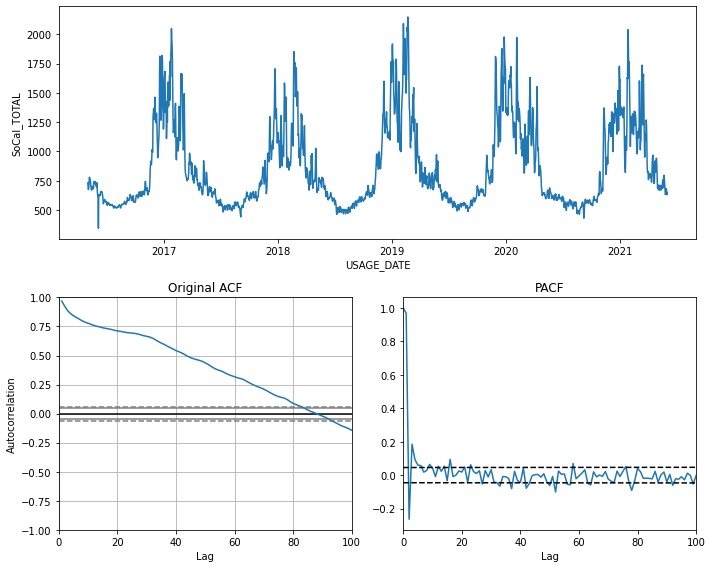

stationary if sig: 0.06481769804644842
11 11


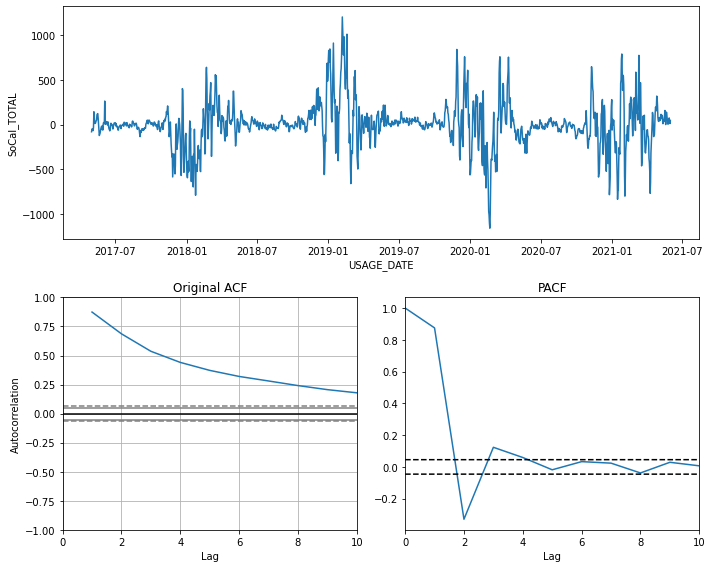

stationary if sig: 8.259619372791452e-06


In [52]:
acf_plots(df['SoCal_TOTAL'], nlags=100, seasonal_m=365) #not sig
seasonal_diff =df['SoCal_TOTAL'].diff(365).dropna()
marks_df = acf_plots(seasonal_diff, nlags=10, seasonal_m=365) #sig

In [ ]:
np.diff(marks_df.index[marks_df['PACF']>marks_df['5CV']]).cumsum()

In [ ]:
# find D via Canova Hanson test to minimize search params for auto_arima seasonal component
pm.arima.utils.nsdiffs(df['SoCal_TOTAL'], 
                      m=365,
                      max_D=12,
                      test='ch')

In [ ]:
# NOTE: Seasonal order cannot exceed 200. For daily data with yearly seasonality (i.e. m=365) 
# seasonality needs to be resolve via FFT added on top of an ARIMA process
# see note in https://robjhyndman.com/hyndsight/longseasonality/

df_test = df[df.index >= pd.to_datetime('4/15/21')] 
df_train = df[df.index < pd.to_datetime('4/15/21')]
arima_fit = pm.auto_arima(df_train['SoCal_TOTAL'], 
                          start_p=25, max_p=33,
                          d=0, 
                          seasonal=True, m=30,
                          start_P=3, max_P=7,
                          D=1, 
                          stepwise=True)
arima_fit.summary()

In [ ]:
days_to_forecast = pd.date_range(start=df_train.index.max(), end = df_train.index.max() + pd.DateOffset(months=6), freq='1d')
predictions = pd.DataFrame({'ARIMA_predict': arima_fit.predict(len(days_to_forecast))})
predictions.index=days_to_forecast

compare_df = pd.concat([df_test['SoCal_TOTAL'], predictions], axis=1).rename(columns={'SoCal_TOTAL': 'Test'})
sns.lineplot(data=df_train['SoCal_TOTAL'], color='k', label='Train')
sns.lineplot(data=compare_df, )
plt.xlim([df_train.index.max() - pd.DateOffset(months=1), predictions.index.max()])
plt.show()

In [ ]:
# transform target data to stationary

lb_test = sm.stats.acorr_ljungbox(df[forecast_column+'_residuals'], lags=[27])

df['SoCal_TOTAL']